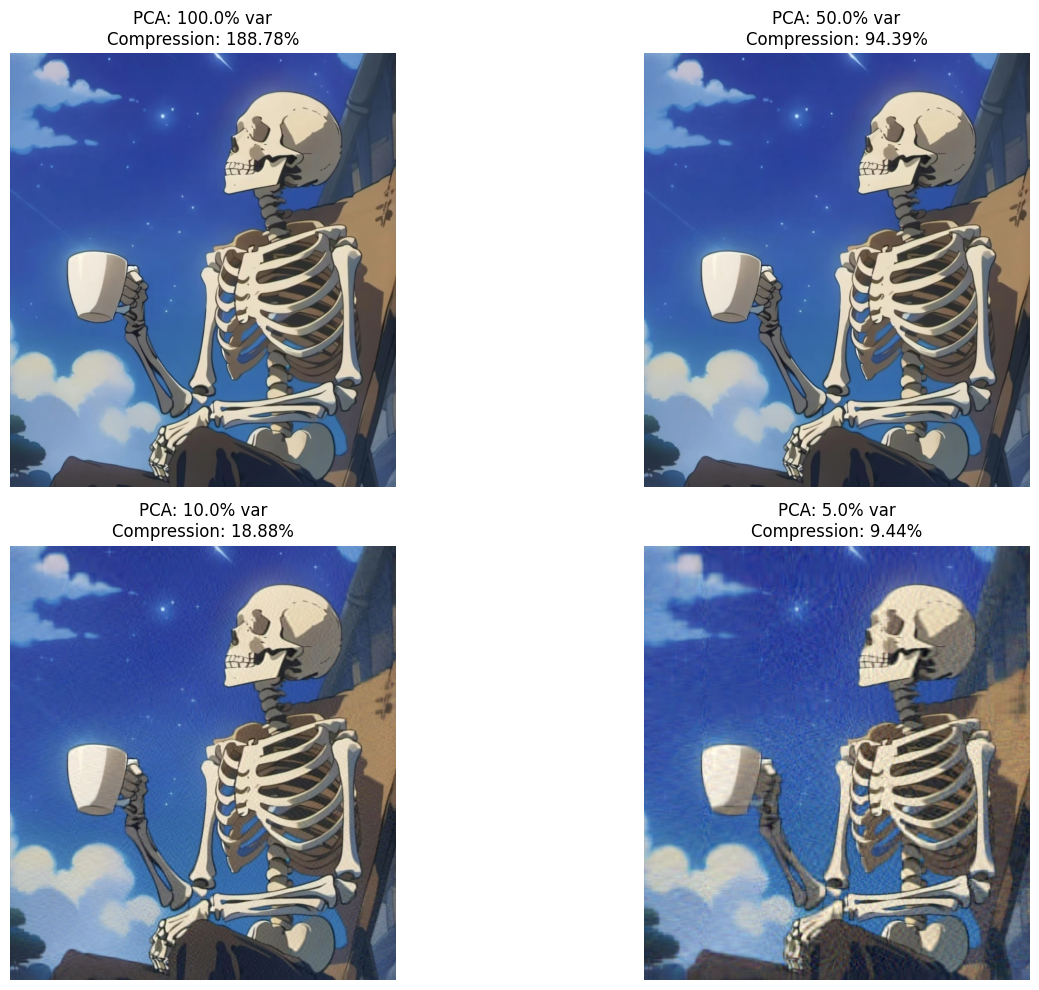

In [12]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 读取图片
img = Image.open('./data/fig/fig1.jpg')
img_array = np.array(img) / 255.0
h, w, c = img_array.shape

# PCA压缩函数
def pca_compress(img_array, compression_ratio):
    compressed_channels = []
    for ch in range(3):  # 分别处理RGB三个通道
        channel_data = img_array[:, :, ch]
        height, width = channel_data.shape
        
        # 计算需要保留的主成分数量
        max_components = min(height, width)
        n_keep = max(1, int(max_components * compression_ratio))
        
        # 应用PCA变换
        pca = PCA(n_components=n_keep)
        transformed = pca.fit_transform(channel_data)
        reconstructed = pca.inverse_transform(transformed)
        
        compressed_channels.append(reconstructed)
    
    return np.clip(np.dstack(compressed_channels), 0, 1)

# 压缩比例计算函数
def calc_compression_ratio(original_shape, n_components, channels=3):
    h, w = original_shape
    return (n_components * (h + w)) / (h * w)

# 处理不同压缩比例
ratios = [1.0, 0.5, 0.1, 0.05]
plt.figure(figsize=(15, 10))

for i, ratio in enumerate(ratios):
    compressed_img = pca_compress(img_array, ratio)
    compression_ratio = calc_compression_ratio((h, w), compressed_img.shape[1]*ratio)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(compressed_img)
    plt.title(f'PCA: {ratio*100}% var\nCompression: {compression_ratio:.2%}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('pca_results.jpg')
plt.show()

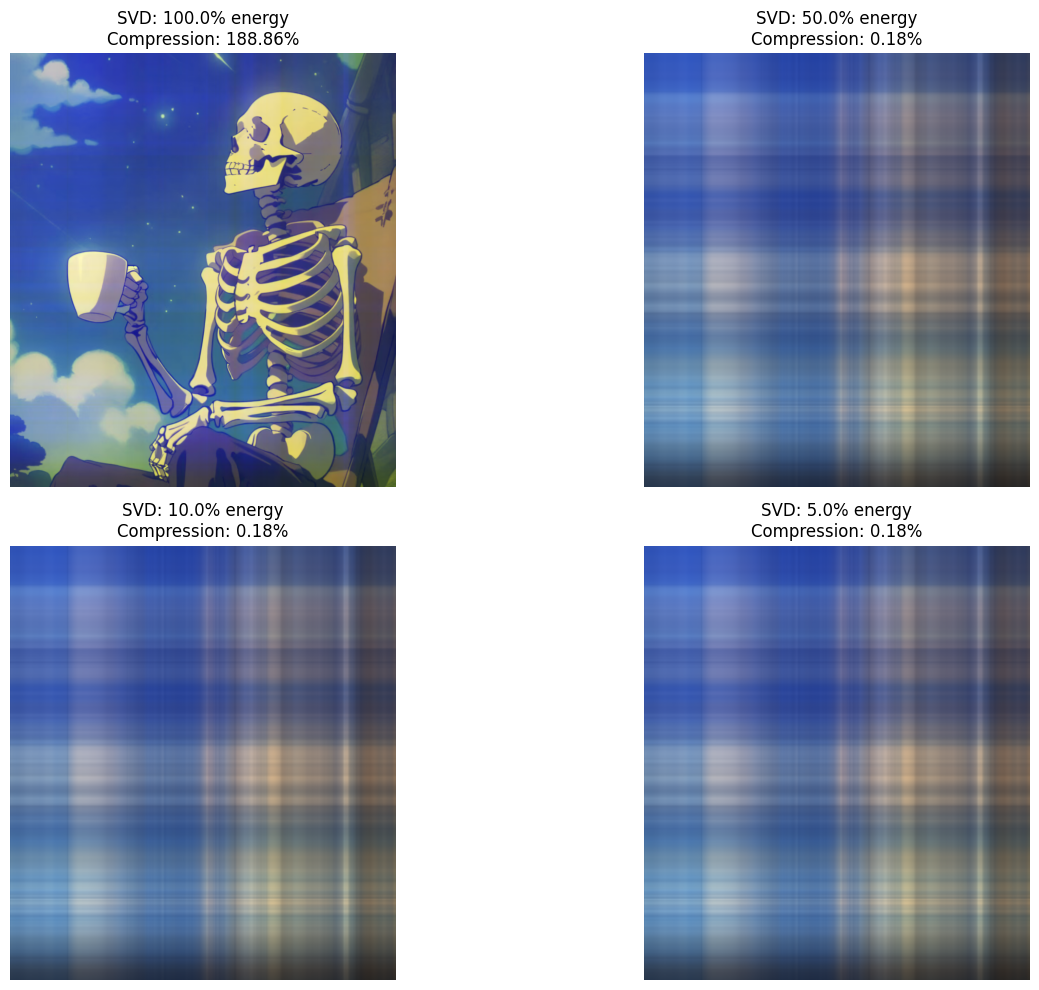

In [9]:
# SVD压缩函数
def svd_compress(img_array, ratio):
    compressed_channels = []
    for ch in range(3):  # 分别处理RGB三个通道
        channel_data = img_array[:, :, ch]
        U, S, Vt = np.linalg.svd(channel_data, full_matrices=False)
        
        # 计算保留指定能量所需的奇异值数
        total_energy = np.sum(S**2)
        cum_energy = np.cumsum(S**2) / total_energy
        n_keep = np.argmax(cum_energy >= ratio) + 1
        
        # 重构图像
        reconstructed = U[:, :n_keep] @ np.diag(S[:n_keep]) @ Vt[:n_keep, :]
        compressed_channels.append(reconstructed)
    
    return np.clip(np.dstack(compressed_channels), 0, 1)

# 压缩比例计算函数
def calc_svd_ratio(original_shape, k):
    h, w = original_shape
    return (k * (h + w + 1)) / (h * w)

# 处理不同压缩比例
plt.figure(figsize=(15, 10))

for i, ratio in enumerate(ratios):
    compressed_img = svd_compress(img_array, ratio)
    U, S, Vt = np.linalg.svd(img_array[:, :, 0])
    total_energy = np.sum(S**2)
    cum_energy = np.cumsum(S**2) / total_energy
    k = np.argmax(cum_energy >= ratio) + 1
    compression_ratio = calc_svd_ratio((h, w), k)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(compressed_img)
    plt.title(f'SVD: {ratio*100}% energy\nCompression: {compression_ratio:.2%}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('svd_results.jpg')
plt.show()

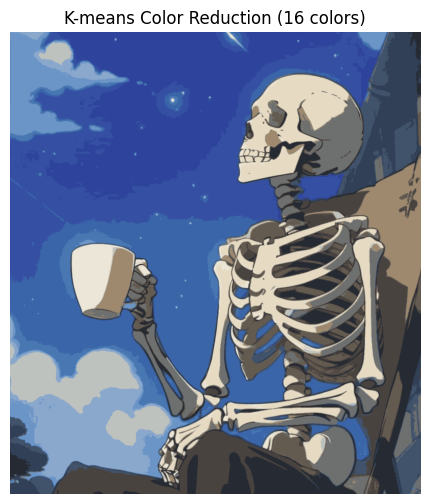

In [10]:
from sklearn.cluster import KMeans

# 转换图像为像素点集
pixels = img_array.reshape((-1, 3))

# K-means聚类降维
kmeans = KMeans(n_clusters=16, random_state=0).fit(pixels)
new_colors = kmeans.cluster_centers_[kmeans.labels_]
compressed_img = new_colors.reshape(img_array.shape)

# 显示结果
plt.figure(figsize=(8, 6))
plt.imshow(compressed_img)
plt.title('K-means Color Reduction (16 colors)')
plt.axis('off')
plt.savefig('kmeans_result.jpg')
plt.show()